# Agentic RAG

[Retrieval Agents](https://python.langchain.com/v0.2/docs/tutorials/qa_chat_history/#agents) are useful when we want to make decisions about whether to retrieve from an index.

To implement a retrieval agent, we simple need to give an LLM access to a retriever tool.

We can incorporate this into [LangGraph](https://langchain-ai.github.io/langgraph/).

## Setup

First, let's download the required packages and set our API keys:

In [1]:
# %%capture --no-stderr
# %pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

In [2]:
import os
import logging
from dotenv import load_dotenv

In [3]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Retriever

First, we index 3 blog posts.

In [6]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_postgres import PGVector
from langchain_postgres.vectorstores import DistanceStrategy
from langchain_core.prompts import PromptTemplate

In [2]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [3]:
len(doc_splits)

563

In [4]:
for doc_split in doc_splits:
    print(doc_split.metadata["title"], "-"*10, doc_split.page_content[:30])

LLM Powered Autonomous Agents | Lil'Log ---------- LLM Powered Autonomous Agents 
LLM Powered Autonomous Agents | Lil'Log ---------- Lil'Log























LLM Powered Autonomous Agents | Lil'Log ---------- LLM Powered Autonomous Agents

LLM Powered Autonomous Agents | Lil'Log ---------- Table of Contents



Agent Sys
LLM Powered Autonomous Agents | Lil'Log ---------- Building agents with LLM (larg
LLM Powered Autonomous Agents | Lil'Log ---------- Agent System Overview#
In a LL
LLM Powered Autonomous Agents | Lil'Log ---------- Planning

Subgoal and decompos
LLM Powered Autonomous Agents | Lil'Log ---------- Memory

Short-term memory: I w
LLM Powered Autonomous Agents | Lil'Log ---------- Tool use

The agent learns to 
LLM Powered Autonomous Agents | Lil'Log ---------- Fig. 1. Overview of a LLM-powe
LLM Powered Autonomous Agents | Lil'Log ---------- Task Decomposition#
Chain of t
LLM Powered Autonomous Agents | Lil'Log ---------- Tree of Thoughts (Yao et al. 2
LLM Powered Auto

In [5]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

database_uri: str = os.getenv("POSTGRES_URI")
database_uri = f"postgresql+psycopg://{database_uri.split('//')[-1]}"

vectorstore = PGVector(
    embeddings=embeddings,
    connection=database_uri,
    collection_name="langgraph_agentic_rag",
    distance_strategy=DistanceStrategy.COSINE,
)

search_kwargs = {
    "k": 5,
    "score_threshold": 0.2,
}

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", search_kwargs=search_kwargs
)


NameError: name 'os' is not defined

In [21]:
# retriever.add_documents(doc_splits)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['c23fb728-dc60-43ac-aea0-11c4ae76f2c8',
 '8234c229-a2ea-4d96-8b71-be77528b299d',
 '12fe873b-79fa-48df-9e4c-ce8222518f1d',
 '99175f78-35ac-48cd-a5bb-545aa465599d',
 'e477d622-8b0d-44e8-91b1-53b27546c1ab',
 '165ba256-d7e5-4d22-a82d-7df18928ad64',
 'f5da4e4a-ecfb-4802-9a68-2eb93fc66b10',
 'bd706e78-98e6-4a51-975a-0611f22fd433',
 '9fec7b07-82f7-40a3-ab89-1141ccdce7ec',
 '03144de3-f2a8-4afb-a8f5-c8538564e952',
 '670c3ed3-6db4-4994-b6ea-db3d256234e3',
 '0ed3d86e-fc53-4861-8b33-eccf92b611cc',
 '8f9bff22-47f6-4a4e-8912-805425d807d2',
 'bd792633-e355-466e-8ba3-614671e3320d',
 'a2ba5dc5-0535-41a4-a200-e14301942237',
 'd7d0a030-cffa-4fc8-92c1-86b4c9750ee0',
 'e54abe86-4bce-4033-b4ee-c6d672710ca8',
 'f837579c-1df9-4586-97b8-6e35cde935c1',
 '60bfa29e-449a-411d-8e7b-1a0be34fec88',
 '702b46a7-3f47-464a-bc1f-4a3f737628e9',
 '542154e3-2e03-4eec-8531-5ae702fa9c63',
 '78768385-f468-4f56-b4cb-a66c4e6dc660',
 '9d5398dc-2242-4206-8732-5e3b164f22e4',
 'f11d949b-1bc6-4b42-859a-3f695922264e',
 'ed16a139-46ef-

In [22]:
relevant_docs = retriever.invoke("Planning is essential")
print(len(relevant_docs))
print(relevant_docs)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


5
[Document(id='151b2291-2cc5-4bac-8a6a-bea183217f2e', metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'language': 'en', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:'}, page_content="Planning & Reacting: translate the reflections and the environment information into actions\n\nPlanning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X's plan today in broad strokes: 1)\nRelation

Then we create a retriever tool.

In [14]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_blog_posts",
    description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
    document_prompt=PromptTemplate.from_template("{page_content}"),
    document_separator="\n\n"
)

tools = [retriever_tool]

## Agent State
 
We will define a graph.

A `state` object that it passes around to each node.

Our state will be a list of `messages`.

Each node in our graph will append to it.

In [15]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Nodes and Edges

We can lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next

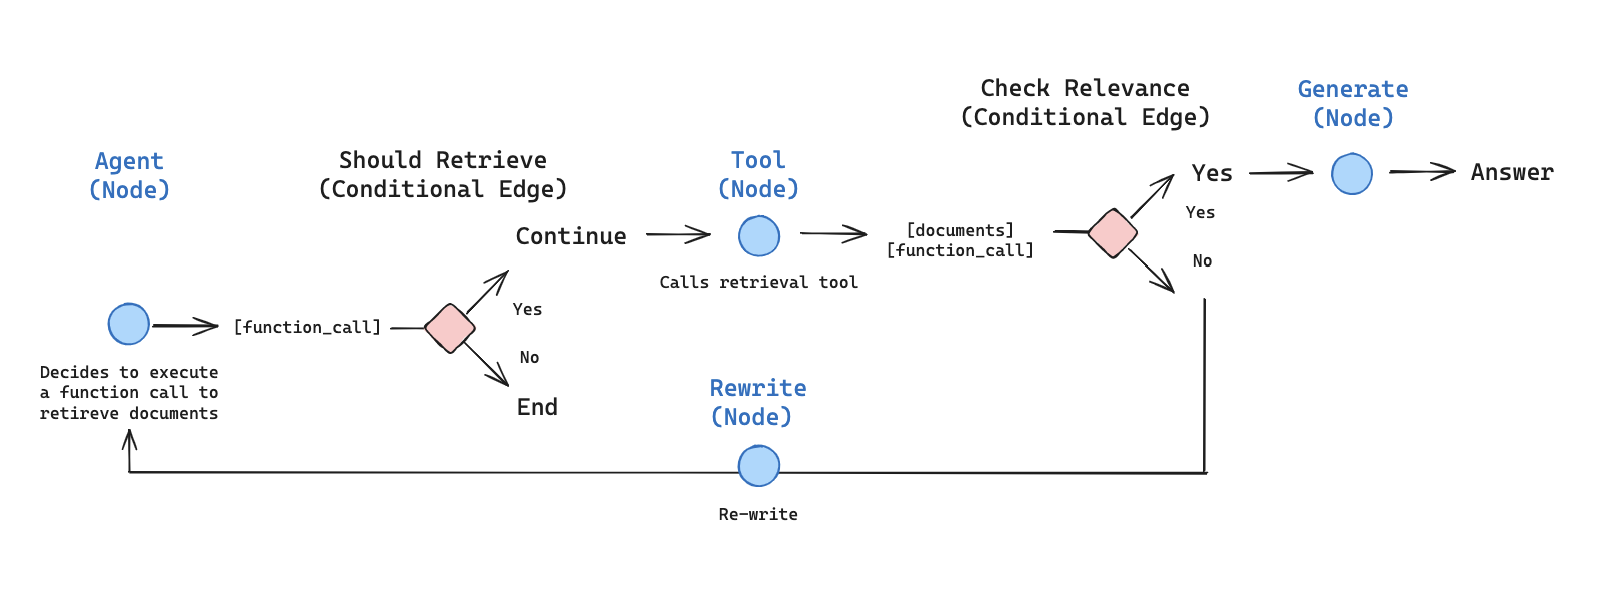

In [17]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
# from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [18]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

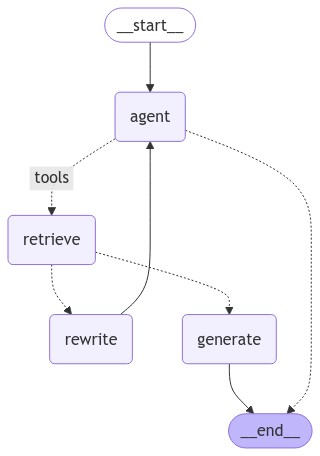

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_m6ieSuBg2p75Rltvf8ImdGL7', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae'}, id='run-fcc6516b-2d69-4c4c-96db-de7f6e61d838-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_m6ieSuBg2p75Rltvf8ImdGL7', 'type': 'tool_call'}])]}
'\n---\n'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


---CHECK RELEVANCE---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nSensory memory as learning embedding representations for raw inputs, including text, image or other modalities;\nShort-term memory as in-context learning. It is short and finite, as it is restricted by the finite context window length of Transformer.\nLong-term memory as the external vector store that the agent can attend to at query time, accessible via fast retrieval.\n\nMemory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.\n\nEach elemen

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Output from node 'generate':"
'---'
{ 'messages': [ 'Lilian Weng describes short-term memory as in-context '
                'learning, which is limited by the finite context window '
                'length of a Transformer. Long-term memory is characterized by '
                'the use of an external vector store that allows the agent to '
                'retain and recall information over extended periods through '
                'fast retrieval. Sensory memory involves learning embedding '
                'representations for raw inputs, such as text and images.']}
'\n---\n'
